# Sentiment analysis with Transfer Learning

In [1]:
import numpy as np
import pandas as pd
import fastai as fai
from fastai import *
from fastai.text import *
from fastai.vision import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

import ctypes
ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

<CDLL 'caffe2_nvrtc.dll', handle 7ffa96f60000 at 0x2f97e8d0b20>

### Load data

In [2]:
ds = pd.read_csv('D:/data/csv/hotel_reviews.csv')
ds.head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968


In [3]:
df_pos = pd.DataFrame(dict(text=ds[ds.Review_Total_Positive_Word_Counts > 2].Positive_Review))
df_pos['score'] = np.ones(len(df_pos), dtype=int)
df_pos.head(3)

,text,score
0,Only the park outside of the hotel was beauti...,1
1,No real complaints the hotel was great great ...,1
2,Location was good and staff were ok It is cut...,1


In [4]:
df_neg = pd.DataFrame(dict(text=ds[ds.Review_Total_Negative_Word_Counts > 2].Negative_Review))
df_neg['score'] = np.zeros(len(df_neg), dtype=int)
df_neg.head(3)

,text,score
0,I am so angry that i made this post available...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,0


In [5]:
df = pd.concat([df_pos, df_neg], axis=0)
df.shape

(822059, 2)

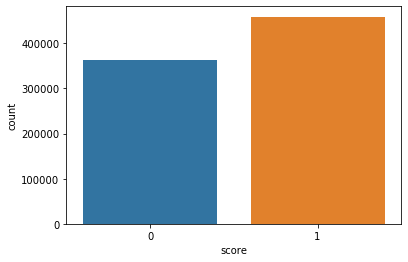

In [6]:
sns.countplot(data=df, x='score');

### Data preparation

In [7]:
df_train, df_test = train_test_split(df[['score', 'text']], test_size=0.2)
df_train = df_train.dropna()
df_test = df_test.dropna()
df_test.head()

,score,text
338449,1,The location was perfect the staff were frien...
451594,1,Hotel amazing staff very friendly Defiantly w...
142017,1,The bed and pillows were really comfy I was o...
156477,1,Nice breakfast and comfortable room
381278,1,Room spacious and comfortable Buffer dinner e...


In [8]:
defaults.cpus=1
data_lm = TextLMDataBunch.from_df('./', df_train, df_test)

In [9]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 'and',
 'was',
 'to',
 'a',
 'room',
 'in',
 'very',
 'staff',
 'of',
 'for']

###  Transfer learning

In [ ]:
learn = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.7)

In [ ]:
learn.predict('What', 100)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
# First, fit only the last softmax layer
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2)

In [61]:
print(learn.predict('xxbos', n_words=100))

xxbos xxbos agresive The Low Case in our Time mile of Rail Road b in Cities West End Industry and Evening society of Push Mill Street Bus Line i Sunday Bus Stop Stop in New York City 2 Hill Road shuts off for a quarter of a for a year at The West End Road charm facility in Empire City in Dual Bridges State Park and


In [62]:
learn.save_encoder('fine_enc')

In [ ]:
# Then unfreeze the model and fit it again
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)

### Sentiment analysis

In [58]:
data_clas = TextClasDataBunch.from_df('./', df_train, df_test, vocab=data_lm.vocab, bs=32)

In [59]:
# Build a classifier with the same architechure and weights as the language model we've just trained 
model = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)

In [63]:
model.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (657647 items)
x: TextList
xxbos breakfast quite expensive for the small amount on offer,xxbos xxmaj the bed and the room were most comfortable xxmaj the xxmaj showers 2 were so refreshing and roomy,xxbos xxmaj the location of this hotel excellent closer to catlunya square xxmaj comfortable bed xxmaj small balcoy but excellent view to the street xxmaj all clean all very good xxmaj thanks to wonderful staff xxmaj brgds xxunk,xxbos xxmaj close to the xxmaj wiener xxmaj musikverein convenient especially after attending the concert,xxbos xxmaj the pillow wasn t very comfortable but the room was lovely
y: CategoryList
0,1,1,1,0
Path: .;

Valid: LabelList (164412 items)
x: TextList
xxbos xxmaj the very comfy goodnight sleep,xxbos xxmaj no kettle provided in the room,xxbos xxmaj the breakfast is xxunk rich,xxbos xxmaj no repairs in the avenue in front,xxbos xxmaj no tea coffee facility xxmaj location next to sex shop no warning given at boo

In [ ]:
model.lr_find()

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
model.recorder.plot()

In [ ]:
model.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
model.recorder.plot_losses()

### Tune hypers

In [ ]:
model = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
model.load_encoder('fine_enc')

In [ ]:
model.lr_find()

In [ ]:
model.recorder.plot()

In [ ]:
model.fit_one_cycle(1, slice(1e-4, 1e-2), moms=(0.8, 0.7))

In [ ]:
model.recorder.plot_lr(show_moms=True)

### Unfreezing

In [ ]:
model = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
model.load_encoder('fine_enc')

In [ ]:
model.lr_find()
model.recorder.plot()

In [ ]:
model.freeze_to(-1)

In [ ]:
model.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
model.unfreeze()
model.freeze_to(-2)
model.fit_one_cycle(1, slice(1e-4, 5e-3), moms=(0.8, 0.7))

In [ ]:
model.unfreeze()
model.freeze_to(-3)
model.fit_one_cycle(1, slice(1e-5, 1e-3), moms=(0.8, 0.7))

In [ ]:
model.unfreeze()
model.fit_one_cycle(1, slice(1e-4/100., 1e-4), moms=(0.8, 0.7))

### Testing & Validation

In [ ]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(losses=losses, y_true=y, probs=preds, learn=classifier)
interp.plot_confusion_matrix()

In [ ]:
rev = [
    'The pool was dirty',
    'Loved our stay in this hotel The rooms were amazingly confortable',
    'water was cold and the room not isolated at all', 
    'could have been better',
    'Staff was amazing'
]

for s in rev:
    print(s, '\n Predicted:', model.predict(s))
    print()

### Credits & Links

https://www.kaggle.com/heisenbad/sentiment-analysis-with-transfer-learning?select=Hotel_Reviews.csv